In [1]:
# Import standard libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import PyTorch and related libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F

# Import Transformers library
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Import sklearn for evaluation metrics
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Import seaborn for visualization
import seaborn as sns

# Import PIL for image processing
from PIL import Image

# For plotting ROC curves
from itertools import cycle


/home/bidl/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Load the CSV annotation files
train_annotations = pd.read_csv("annotations_train.csv")
test_annotations = pd.read_csv("annotations_test.csv")


In [3]:
# Remove rows where 'class_name' is 'No finding'
train_annotations = train_annotations[train_annotations['class_name'] != "No finding"]


In [4]:
# Add 'image_path' column to the DataFrame
train_annotations['image_path'] = train_annotations['image_id'].apply(
    lambda x: os.path.join('train', f'{x}.png'))


In [5]:
# Load the existing COCO annotations
import json

with open('train_annotations_coco.json', 'r') as f:
    coco_data = json.load(f)

# Extract images, annotations, and categories
images_info = coco_data['images']
annotations_info = coco_data['annotations']
categories_info = coco_data['categories']

# Map category_id to category name
category_id_to_name = {category['id']: category['name'] for category in categories_info}

# Identify the 'No finding' category_id
no_findings_category_id = None
for category in categories_info:
    if category['name'].lower() == 'no finding':
        no_findings_category_id = category['id']
        break


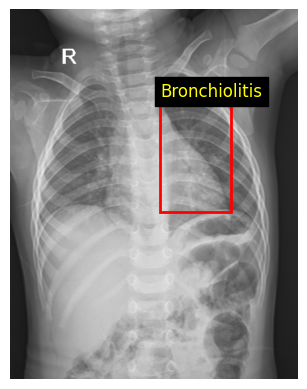

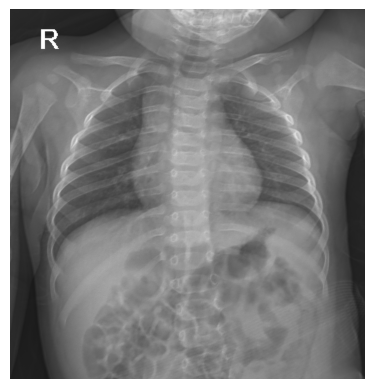

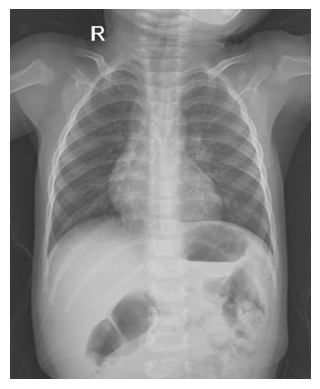

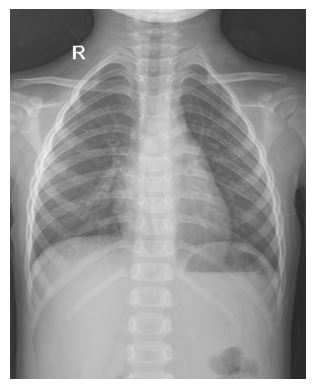

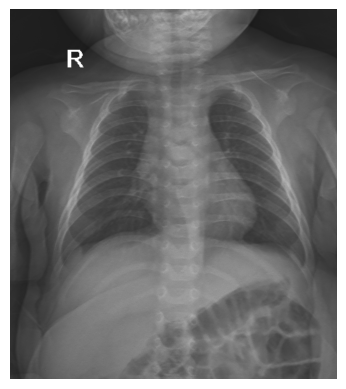

In [6]:
def visualize_coco_image(image_info, annotations, category_id_to_name):
    image_file_name = image_info['file_name']
    image_path = os.path.join('train', image_file_name)
    
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Image {image_file_name} not found.")
        return
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for annotation in annotations:
        if annotation['image_id'] == image_info['id']:
            bbox = annotation['bbox']
            category_id = annotation['category_id']
            category_name = category_id_to_name.get(category_id, 'Unknown')
            
            if category_id == no_findings_category_id:
                continue
            
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, category_name, color='yellow',
                     fontsize=12, backgroundcolor="black")
    
    plt.axis('off')
    plt.show()

# Visualize five random images
random_sample_images = random.sample(images_info, 5)
for sample_image_info in random_sample_images:
    sample_annotations = [ann for ann in annotations_info
                          if ann['image_id'] == sample_image_info['id']
                          and ann['category_id'] != no_findings_category_id]
    visualize_coco_image(sample_image_info, sample_annotations, category_id_to_name)


In [7]:
# Filter out 'No findings' annotations
filtered_annotations = [ann for ann in annotations_info
                        if ann['category_id'] != no_findings_category_id]

# Get valid image IDs
valid_image_ids = {ann['image_id'] for ann in filtered_annotations}
filtered_images = [img for img in images_info if img['id'] in valid_image_ids]

# Split into train and validation sets
train_images, val_images = train_test_split(filtered_images, test_size=0.2, random_state=42)

# Create annotations for train and validation
train_image_ids = {img['id'] for img in train_images}
val_image_ids = {img['id'] for img in val_images}

train_annotations = [ann for ann in filtered_annotations if ann['image_id'] in train_image_ids]
val_annotations = [ann for ann in filtered_annotations if ann['image_id'] in val_image_ids]

# Save to new JSON files if needed
train_data = {
    'images': train_images,
    'annotations': train_annotations,
    'categories': categories_info
}

val_data = {
    'images': val_images,
    'annotations': val_annotations,
    'categories': categories_info
}

with open('filtered_train_annotations_coco.json', 'w') as f:
    json.dump(train_data, f)

with open('filtered_val_annotations_coco.json', 'w') as f:
    json.dump(val_data, f)


In [8]:
class CustomCOCODataset(Dataset):
    def __init__(self, annotations, images, transform=None, image_dir='train/'):
        self.annotations = annotations
        self.images = images
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image {img_info['file_name']} not found at {img_path}.")
            return None, None
        
        # Get annotations for this image
        annots = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        # Use the first category_id as the label
        if len(annots) > 0:
            label = annots[0]['category_id'] - 1  # Subtract 1 to make labels start from 0
        else:
            label = 0  # Default label
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [9]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CustomCOCODataset(train_annotations, train_images, transform=transform)
val_dataset = CustomCOCODataset(val_annotations, val_images, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [10]:
# Initialize feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
num_classes = len(categories_info) - 1  # Exclude 'No finding' class
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', num_labels=num_classes)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/home/bidl/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [11]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Store training and validation losses
train_losses = []
val_losses = []

# Number of epochs
num_epochs = 14

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, labels in train_loader:
        if images is None or labels is None:
            continue
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if images is None or labels is None:
                continue
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch 1/14, Training Loss: 1.6669, Validation Loss: 1.5049
Epoch 2/14, Training Loss: 1.4029, Validation Loss: 1.3521
Epoch 3/14, Training Loss: 0.9670, Validation Loss: 0.9103
Epoch 4/14, Training Loss: 0.4928, Validation Loss: 0.7855
Epoch 5/14, Training Loss: 0.2521, Validation Loss: 0.6660
Epoch 6/14, Training Loss: 0.1540, Validation Loss: 0.6560
Epoch 7/14, Training Loss: 0.1254, Validation Loss: 0.7132
Epoch 8/14, Training Loss: 0.0868, Validation Loss: 0.6997
Epoch 9/14, Training Loss: 0.0932, Validation Loss: 0.7097
Epoch 10/14, Training Loss: 0.0578, Validation Loss: 0.8009
Epoch 11/14, Training Loss: 0.0505, Validation Loss: 0.7588
Epoch 12/14, Training Loss: 0.0561, Validation Loss: 0.8356
Epoch 13/14, Training Loss: 0.0716, Validation Loss: 0.7879
Epoch 14/14, Training Loss: 0.0516, Validation Loss: 0.8181


In [12]:
# Save the model
model_save_path = "vit_model_final22.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vit_model_final22.pth


In [13]:
# Load the model
model_load_path = "vit_model_final22.pth"
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', num_labels=num_classes)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully.")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_514628/1722110948.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

Model loaded successfully.


In [14]:
# Initialize lists to store true labels and predicted probabilities
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        if images is None or labels is None:
            continue
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Calculate predicted classes
all_preds = np.argmax(all_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(cm)


Validation Accuracy: 82.83%
Precision: 0.83
Recall: 0.83
F1 Score: 0.82
Confusion Matrix:
[[304   6   4  12   0   0   0   0   0   0]
 [ 12 248   3  18   0   0   0   0   0   0]
 [ 27   5  57  12   0   5   0   0   0   0]
 [ 13   4   5 177   0   0   0   0   0   0]
 [  1   0   0   0   3   0   0   0   0   0]
 [ 13   4   7  24   0  63   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1]]


/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


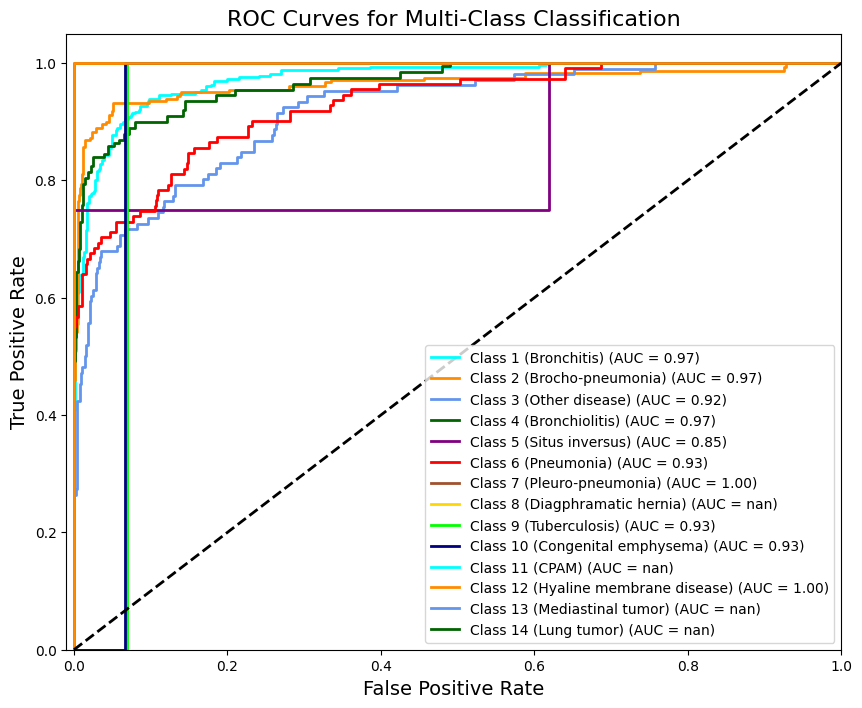

In [15]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
n_classes = num_classes
all_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen',
                'purple', 'red', 'sienna', 'gold', 'lime', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} ({1}) (AUC = {2:0.2f})'
             ''.format(i+1, category_id_to_name.get(i+1, 'Unknown'), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower right")
plt.show()


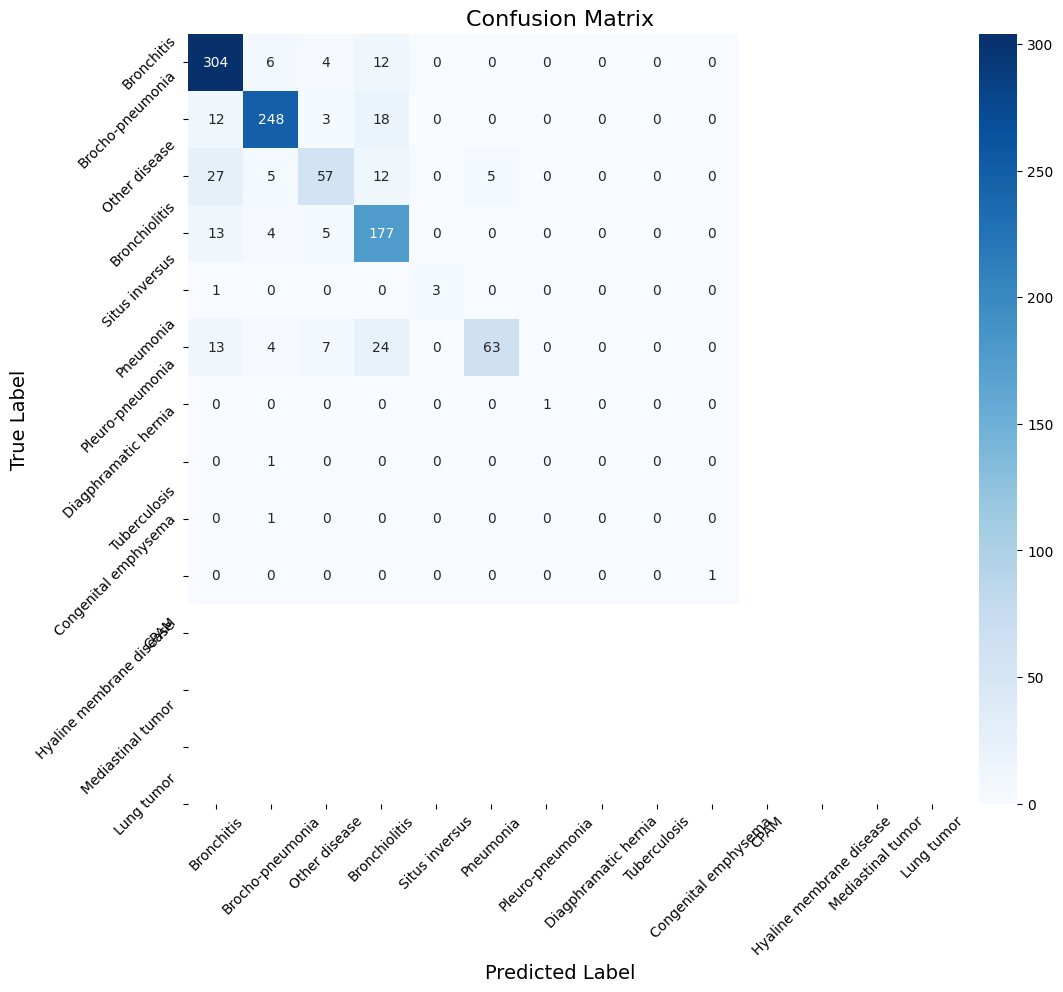

In [16]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[category_id_to_name[i+1] for i in range(n_classes)],
            yticklabels=[category_id_to_name[i+1] for i in range(n_classes)])
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/bidl/.local/lib/python3.10/site-packages/sklearn/metrics/_r

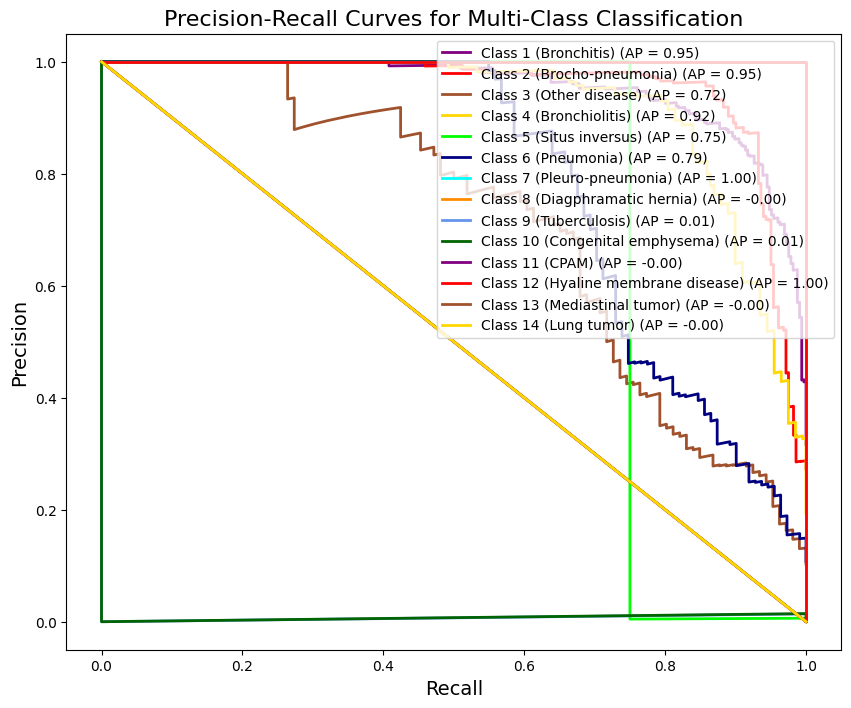

In [17]:
# Compute Precision-Recall and plot curve for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_binarized[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(all_labels_binarized[:, i], all_probs[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} ({1}) (AP = {2:0.2f})'
             ''.format(i+1, category_id_to_name.get(i+1, 'Unknown'), average_precision[i]))

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="upper right")
plt.show()


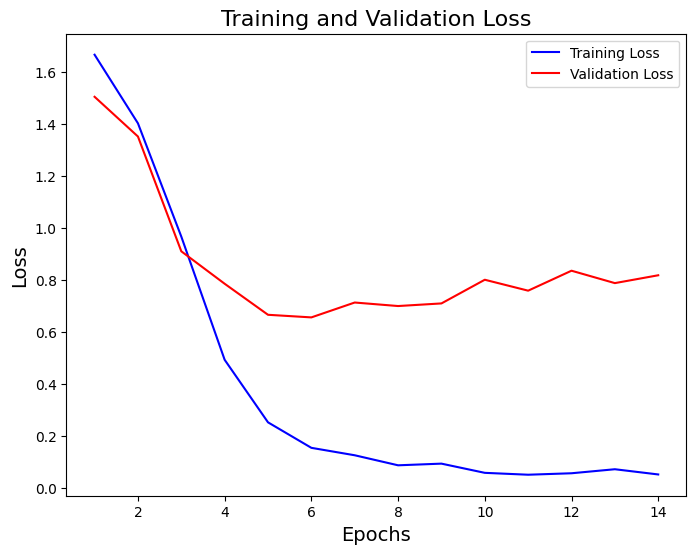

In [18]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.show()


In [22]:
# Generate the classification report
report = classification_report(all_labels, all_preds,
                               labels=unique_labels,
                               target_names=target_names,
                               zero_division=0)
print(report)


                          precision    recall  f1-score   support

              Bronchitis       0.82      0.93      0.87       326
        Brocho-pneumonia       0.92      0.88      0.90       281
           Other disease       0.75      0.54      0.63       106
           Bronchiolitis       0.73      0.89      0.80       199
          Situs inversus       1.00      0.75      0.86         4
               Pneumonia       0.93      0.57      0.70       111
        Pleuro-pneumonia       1.00      1.00      1.00         1
            Tuberculosis       0.00      0.00      0.00         1
    Congenital emphysema       0.00      0.00      0.00         1
Hyaline membrane disease       1.00      1.00      1.00         1

                accuracy                           0.83      1031
               macro avg       0.71      0.66      0.68      1031
            weighted avg       0.83      0.83      0.82      1031



In [20]:
# Get unique labels from the validation data
unique_labels = np.unique(all_labels)


In [21]:
# Map labels to category names
target_names = [category_id_to_name[label + 1] for label in unique_labels]


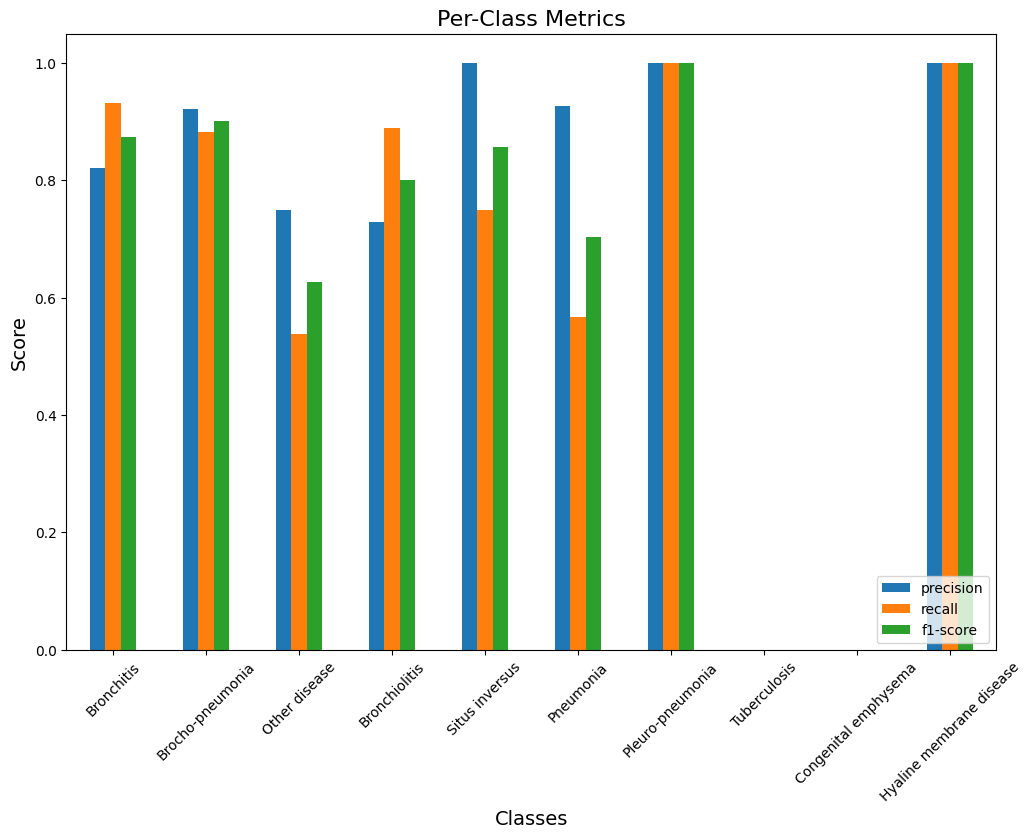

In [23]:
### 19. Visualize Per-Class Metrics

# Get the report as a dictionary
report_dict = classification_report(all_labels, all_preds,
                                    labels=unique_labels,
                                    target_names=target_names,
                                    zero_division=0, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Exclude 'accuracy', 'macro avg', 'weighted avg'
report_df = report_df.iloc[:-3, :]

# Plot Precision, Recall, and F1-Score
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 8))
plt.title('Per-Class Metrics', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()
